# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ad79d3ca981f5ed810d69e4657d7d35ca2768f084a94c3e1713412b5a5d3f562
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 63% 9.00M/14.3M [00:00<00:00, 12.9MB/s]
100% 14.3M/14.3M [00:00<00:00, 21.0MB/s]
 94% 110M/117M [00:01<00:00, 85.9MB/s] 
100% 117M/117M [00:01<00:00, 66.3MB/s]


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 15.1 MB/s 
     |████████████████████████████████| 948 kB 62.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=a6b8cca704123e721596e62069c377120df725a74a87c2b53bc3a5bd9f06d03c
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [4]:
class Config:
    Version = "exp25" # model save時のversion
    MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b2_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "swin_large_patch4_window7_224"
    #MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    #MODEL_NAME = "swin_large_patch4_window12_384"
    #MODEL_NAME = "swin_base_patch4_window12_384"


    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5    
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b2_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  128 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    alpha = 0.2
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        # self.data = []
        # self.targets = []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']
        
        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Mixup

In [12]:
def mixup(x, y, alpha=Config.alpha):

    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

# Model

In [13]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.fc.in_features #self.model.num_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [14]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    #https://colab.research.google.com/github/tan5o/Data-Augmentation-Method-Comparison-of-Cifar-100/blob/master/cifer100_pytorch_mixup.ipynb#scrollTo=iSq4oO_zjpnI
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ

        mix_images, target_a, target_b, lam = mixup(images, labels, alpha=1.0)

        _imgs = mix_images.to('cpu').detach().numpy()
        imgs = np.transpose(_imgs, (0, 2, 3, 1))
        
        # mix_images = images.to(Config.device)
        # target_a = target_a.to(Config.device)
        # target_b = target_b.to(Config.device)

        batch_size = labels.size(0) 
        y_preds = model(mix_images) # 予測ラベル model(mix_images) 
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [15]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [16]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

,image_id,label
0,../input/animal-imbalance-classification-round...,0
1,../input/animal-imbalance-classification-round...,0
2,../input/animal-imbalance-classification-round...,0
3,../input/animal-imbalance-classification-round...,0
4,../input/animal-imbalance-classification-round...,0


In [17]:
#train['image_id'][0]

In [18]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [19]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [20]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

,image_id,label,folds
0,../input/animal-imbalance-classification-round...,0,1
1,../input/animal-imbalance-classification-round...,0,1
2,../input/animal-imbalance-classification-round...,0,1
3,../input/animal-imbalance-classification-round...,0,1
4,../input/animal-imbalance-classification-round...,0,0
...,...,...,...
36495,../input/animal-imbalance-classification-round...,9,1
36496,../input/animal-imbalance-classification-round...,9,1
36497,../input/animal-imbalance-classification-round...,9,1
36498,../input/animal-imbalance-classification-round...,9,1


#### 平均と標準偏差を計算

In [21]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [22]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [23]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [24]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

### 最適化関数

In [25]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

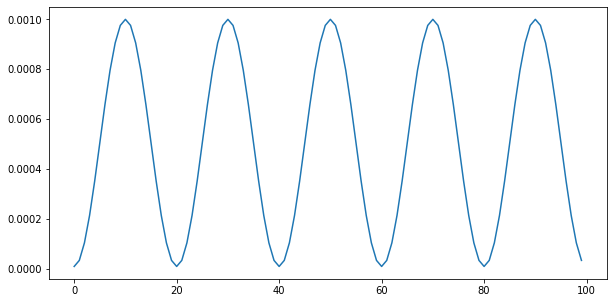

In [26]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [27]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [28]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/228] Data 3.391 (3.391) Elapsed 0m 4s (remain 18m 32s) Loss: 6.9413(6.9413) 
Epoch: [1][227/228] Data 0.000 (0.017) Elapsed 2m 12s (remain 0m 0s) Loss: 6.6671(6.7950) 
EVAL: [0/58] Data 1.121 (1.121) Elapsed 0m 1s (remain 1m 14s) Loss: 6.9428(6.9428) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 14s (remain 0m 0s) Loss: 6.8159(6.5813) 


Epoch 1 - avg_train_loss: 6.7950  avg_val_loss: 6.5813  time: 147s
Epoch 1 - Accuracy: 0.09232876712328768
Epoch 1 - Save Best Score: 0.0923 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [2][0/228] Data 1.561 (1.561) Elapsed 0m 2s (remain 9m 8s) Loss: 6.6393(6.6393) 
Epoch: [2][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 5.1201(5.9879) 
EVAL: [0/58] Data 1.198 (1.198) Elapsed 0m 1s (remain 1m 20s) Loss: 4.5518(4.5518) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 14s (remain 0m 0s) Loss: 5.6035(4.7909) 


Epoch 2 - avg_train_loss: 5.9879  avg_val_loss: 4.7909  time: 141s
Epoch 2 - Accuracy: 0.2721917808219178
Epoch 2 - Save Best Score: 0.2722 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [3][0/228] Data 1.770 (1.770) Elapsed 0m 2s (remain 9m 39s) Loss: 5.3132(5.3132) 
Epoch: [3][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.0272(3.1494) 
EVAL: [0/58] Data 1.366 (1.366) Elapsed 0m 1s (remain 1m 27s) Loss: 1.5887(1.5887) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 13s (remain 0m 0s) Loss: 4.2681(1.8945) 


Epoch 3 - avg_train_loss: 3.1494  avg_val_loss: 1.8945  time: 141s
Epoch 3 - Accuracy: 0.3854794520547945
Epoch 3 - Save Best Score: 0.3855 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [4][0/228] Data 1.465 (1.465) Elapsed 0m 2s (remain 8m 49s) Loss: 1.8327(1.8327) 
Epoch: [4][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.1312(2.0187) 
EVAL: [0/58] Data 1.317 (1.317) Elapsed 0m 1s (remain 1m 24s) Loss: 1.2944(1.2944) 
EVAL: [57/58] Data 0.000 (0.090) Elapsed 0m 14s (remain 0m 0s) Loss: 3.8935(1.6833) 


Epoch 4 - avg_train_loss: 2.0187  avg_val_loss: 1.6833  time: 141s
Epoch 4 - Accuracy: 0.4398630136986301
Epoch 4 - Save Best Score: 0.4399 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [5][0/228] Data 1.658 (1.658) Elapsed 0m 2s (remain 9m 15s) Loss: 1.8064(1.8064) 
Epoch: [5][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.6285(1.8972) 
EVAL: [0/58] Data 1.035 (1.035) Elapsed 0m 1s (remain 1m 8s) Loss: 1.3605(1.3605) 
EVAL: [57/58] Data 0.000 (0.088) Elapsed 0m 14s (remain 0m 0s) Loss: 3.2090(1.5647) 


Epoch 5 - avg_train_loss: 1.8972  avg_val_loss: 1.5647  time: 141s
Epoch 5 - Accuracy: 0.45835616438356164
Epoch 5 - Save Best Score: 0.4584 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [6][0/228] Data 1.521 (1.521) Elapsed 0m 2s (remain 9m 6s) Loss: 2.2795(2.2795) 
Epoch: [6][227/228] Data 0.000 (0.007) Elapsed 2m 6s (remain 0m 0s) Loss: 2.1790(1.8912) 
EVAL: [0/58] Data 1.237 (1.237) Elapsed 0m 1s (remain 1m 20s) Loss: 1.3688(1.3688) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 13s (remain 0m 0s) Loss: 3.2296(1.5276) 


Epoch 6 - avg_train_loss: 1.8912  avg_val_loss: 1.5276  time: 141s
Epoch 6 - Accuracy: 0.49219178082191783
Epoch 6 - Save Best Score: 0.4922 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [7][0/228] Data 1.575 (1.575) Elapsed 0m 2s (remain 9m 14s) Loss: 1.5144(1.5144) 
Epoch: [7][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.4581(1.8919) 
EVAL: [0/58] Data 1.238 (1.238) Elapsed 0m 1s (remain 1m 20s) Loss: 1.0843(1.0843) 
EVAL: [57/58] Data 0.000 (0.091) Elapsed 0m 14s (remain 0m 0s) Loss: 3.4184(1.5093) 


Epoch 7 - avg_train_loss: 1.8919  avg_val_loss: 1.5093  time: 141s
Epoch 7 - Accuracy: 0.4482191780821918


Epoch: [8][0/228] Data 1.540 (1.540) Elapsed 0m 2s (remain 8m 55s) Loss: 1.5500(1.5500) 
Epoch: [8][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.3611(1.9030) 
EVAL: [0/58] Data 1.332 (1.332) Elapsed 0m 1s (remain 1m 26s) Loss: 1.4679(1.4679) 
EVAL: [57/58] Data 0.000 (0.093) Elapsed 0m 14s (remain 0m 0s) Loss: 3.2816(1.5155) 


Epoch 8 - avg_train_loss: 1.9030  avg_val_loss: 1.5155  time: 142s
Epoch 8 - Accuracy: 0.4986301369863014
Epoch 8 - Save Best Score: 0.4986 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [9][0/228] Data 1.597 (1.597) Elapsed 0m 2s (remain 9m 17s) Loss: 1.7193(1.7193) 
Epoch: [9][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.2104(1.8874) 
EVAL: [0/58] Data 1.080 (1.080) Elapsed 0m 1s (remain 1m 10s) Loss: 1.2308(1.2308) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 2.9122(1.4738) 


Epoch 9 - avg_train_loss: 1.8874  avg_val_loss: 1.4738  time: 141s
Epoch 9 - Accuracy: 0.48561643835616436


Epoch: [10][0/228] Data 1.674 (1.674) Elapsed 0m 2s (remain 9m 24s) Loss: 2.3287(2.3287) 
Epoch: [10][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.3252(1.8556) 
EVAL: [0/58] Data 1.350 (1.350) Elapsed 0m 1s (remain 1m 26s) Loss: 1.1457(1.1457) 
EVAL: [57/58] Data 0.000 (0.094) Elapsed 0m 14s (remain 0m 0s) Loss: 2.5753(1.4688) 


Epoch 10 - avg_train_loss: 1.8556  avg_val_loss: 1.4688  time: 141s
Epoch 10 - Accuracy: 0.48712328767123286


Epoch: [11][0/228] Data 1.552 (1.552) Elapsed 0m 2s (remain 9m 12s) Loss: 1.8583(1.8583) 
Epoch: [11][227/228] Data 0.000 (0.008) Elapsed 2m 7s (remain 0m 0s) Loss: 2.5249(1.8471) 
EVAL: [0/58] Data 1.359 (1.359) Elapsed 0m 1s (remain 1m 27s) Loss: 1.3210(1.3210) 
EVAL: [57/58] Data 0.000 (0.095) Elapsed 0m 14s (remain 0m 0s) Loss: 3.8485(1.4588) 


Epoch 11 - avg_train_loss: 1.8471  avg_val_loss: 1.4588  time: 142s
Epoch 11 - Accuracy: 0.5105479452054794
Epoch 11 - Save Best Score: 0.5105 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [12][0/228] Data 1.534 (1.534) Elapsed 0m 2s (remain 9m 16s) Loss: 1.7320(1.7320) 
Epoch: [12][227/228] Data 0.000 (0.007) Elapsed 2m 6s (remain 0m 0s) Loss: 1.6463(1.8104) 
EVAL: [0/58] Data 1.259 (1.259) Elapsed 0m 1s (remain 1m 23s) Loss: 1.1240(1.1240) 
EVAL: [57/58] Data 0.000 (0.086) Elapsed 0m 14s (remain 0m 0s) Loss: 3.1646(1.4611) 


Epoch 12 - avg_train_loss: 1.8104  avg_val_loss: 1.4611  time: 141s
Epoch 12 - Accuracy: 0.5383561643835616
Epoch 12 - Save Best Score: 0.5384 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [13][0/228] Data 1.543 (1.543) Elapsed 0m 2s (remain 9m 2s) Loss: 1.5672(1.5672) 
Epoch: [13][227/228] Data 0.000 (0.008) Elapsed 2m 7s (remain 0m 0s) Loss: 1.8667(1.8377) 
EVAL: [0/58] Data 1.068 (1.068) Elapsed 0m 1s (remain 1m 10s) Loss: 1.2145(1.2145) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 2.7678(1.3462) 


Epoch 13 - avg_train_loss: 1.8377  avg_val_loss: 1.3462  time: 142s
Epoch 13 - Accuracy: 0.5613698630136986
Epoch 13 - Save Best Score: 0.5614 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [14][0/228] Data 1.682 (1.682) Elapsed 0m 2s (remain 9m 39s) Loss: 2.0094(2.0094) 
Epoch: [14][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.5029(1.7573) 
EVAL: [0/58] Data 1.140 (1.140) Elapsed 0m 1s (remain 1m 14s) Loss: 0.7822(0.7822) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 3.0139(1.2520) 


Epoch 14 - avg_train_loss: 1.7573  avg_val_loss: 1.2520  time: 142s
Epoch 14 - Accuracy: 0.5780821917808219
Epoch 14 - Save Best Score: 0.5781 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [15][0/228] Data 1.648 (1.648) Elapsed 0m 2s (remain 9m 14s) Loss: 1.3601(1.3601) 
Epoch: [15][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 2.0255(1.7831) 
EVAL: [0/58] Data 1.155 (1.155) Elapsed 0m 1s (remain 1m 15s) Loss: 0.9628(0.9628) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 3.2961(1.2479) 


Epoch 15 - avg_train_loss: 1.7831  avg_val_loss: 1.2479  time: 141s
Epoch 15 - Accuracy: 0.6172602739726027
Epoch 15 - Save Best Score: 0.6173 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [16][0/228] Data 1.496 (1.496) Elapsed 0m 2s (remain 8m 54s) Loss: 1.3387(1.3387) 
Epoch: [16][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.8990(1.7309) 
EVAL: [0/58] Data 0.836 (0.836) Elapsed 0m 0s (remain 0m 56s) Loss: 0.8194(0.8194) 
EVAL: [57/58] Data 0.000 (0.079) Elapsed 0m 13s (remain 0m 0s) Loss: 2.6828(1.1628) 


Epoch 16 - avg_train_loss: 1.7309  avg_val_loss: 1.1628  time: 140s
Epoch 16 - Accuracy: 0.6391780821917808
Epoch 16 - Save Best Score: 0.6392 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [17][0/228] Data 1.619 (1.619) Elapsed 0m 2s (remain 9m 20s) Loss: 1.1882(1.1882) 
Epoch: [17][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.3239(1.7041) 
EVAL: [0/58] Data 1.113 (1.113) Elapsed 0m 1s (remain 1m 12s) Loss: 0.9608(0.9608) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 13s (remain 0m 0s) Loss: 2.7723(1.1931) 


Epoch 17 - avg_train_loss: 1.7041  avg_val_loss: 1.1931  time: 140s
Epoch 17 - Accuracy: 0.6405479452054794
Epoch 17 - Save Best Score: 0.6405 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [18][0/228] Data 1.745 (1.745) Elapsed 0m 2s (remain 9m 33s) Loss: 2.2753(2.2753) 
Epoch: [18][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.3381(1.7828) 
EVAL: [0/58] Data 1.136 (1.136) Elapsed 0m 1s (remain 1m 14s) Loss: 0.7881(0.7881) 
EVAL: [57/58] Data 0.000 (0.081) Elapsed 0m 13s (remain 0m 0s) Loss: 2.7786(1.1782) 


Epoch 18 - avg_train_loss: 1.7828  avg_val_loss: 1.1782  time: 140s
Epoch 18 - Accuracy: 0.656986301369863
Epoch 18 - Save Best Score: 0.6570 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [19][0/228] Data 1.527 (1.527) Elapsed 0m 2s (remain 9m 11s) Loss: 1.2413(1.2413) 
Epoch: [19][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.5557(1.6599) 
EVAL: [0/58] Data 1.164 (1.164) Elapsed 0m 1s (remain 1m 16s) Loss: 0.6313(0.6313) 
EVAL: [57/58] Data 0.000 (0.089) Elapsed 0m 14s (remain 0m 0s) Loss: 2.6997(1.1101) 


Epoch 19 - avg_train_loss: 1.6599  avg_val_loss: 1.1101  time: 141s
Epoch 19 - Accuracy: 0.6608219178082192
Epoch 19 - Save Best Score: 0.6608 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [20][0/228] Data 1.526 (1.526) Elapsed 0m 2s (remain 8m 55s) Loss: 2.3107(2.3107) 
Epoch: [20][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.0906(1.6846) 
EVAL: [0/58] Data 1.454 (1.454) Elapsed 0m 1s (remain 1m 33s) Loss: 0.6711(0.6711) 
EVAL: [57/58] Data 0.000 (0.081) Elapsed 0m 13s (remain 0m 0s) Loss: 2.6711(1.1186) 


Epoch 20 - avg_train_loss: 1.6846  avg_val_loss: 1.1186  time: 140s
Epoch 20 - Accuracy: 0.6654794520547945
Epoch 20 - Save Best Score: 0.6655 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [21][0/228] Data 1.468 (1.468) Elapsed 0m 2s (remain 8m 44s) Loss: 1.1125(1.1125) 
Epoch: [21][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.8541(1.6857) 
EVAL: [0/58] Data 1.203 (1.203) Elapsed 0m 1s (remain 1m 17s) Loss: 0.6772(0.6772) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 2.6613(1.1159) 


Epoch 21 - avg_train_loss: 1.6857  avg_val_loss: 1.1159  time: 140s
Epoch 21 - Accuracy: 0.6687671232876712
Epoch 21 - Save Best Score: 0.6688 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [22][0/228] Data 1.573 (1.573) Elapsed 0m 2s (remain 9m 11s) Loss: 1.0794(1.0794) 
Epoch: [22][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.4845(1.6902) 
EVAL: [0/58] Data 1.136 (1.136) Elapsed 0m 1s (remain 1m 15s) Loss: 0.7050(0.7050) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 13s (remain 0m 0s) Loss: 2.6667(1.1173) 


Epoch 22 - avg_train_loss: 1.6902  avg_val_loss: 1.1173  time: 141s
Epoch 22 - Accuracy: 0.6775342465753424
Epoch 22 - Save Best Score: 0.6775 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [23][0/228] Data 1.622 (1.622) Elapsed 0m 2s (remain 9m 15s) Loss: 2.3596(2.3596) 
Epoch: [23][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.6622(1.7282) 
EVAL: [0/58] Data 1.089 (1.089) Elapsed 0m 1s (remain 1m 11s) Loss: 0.7294(0.7294) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 14s (remain 0m 0s) Loss: 2.7410(1.1324) 


Epoch 23 - avg_train_loss: 1.7282  avg_val_loss: 1.1324  time: 141s
Epoch 23 - Accuracy: 0.6735616438356165


Epoch: [24][0/228] Data 1.443 (1.443) Elapsed 0m 2s (remain 8m 44s) Loss: 1.3898(1.3898) 
Epoch: [24][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.3260(1.7117) 
EVAL: [0/58] Data 1.221 (1.221) Elapsed 0m 1s (remain 1m 22s) Loss: 0.8074(0.8074) 
EVAL: [57/58] Data 0.000 (0.080) Elapsed 0m 13s (remain 0m 0s) Loss: 2.4988(1.1241) 


Epoch 24 - avg_train_loss: 1.7117  avg_val_loss: 1.1241  time: 140s
Epoch 24 - Accuracy: 0.6773972602739726


Epoch: [25][0/228] Data 1.488 (1.488) Elapsed 0m 2s (remain 8m 53s) Loss: 1.2571(1.2571) 
Epoch: [25][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.5086(1.7073) 
EVAL: [0/58] Data 1.114 (1.114) Elapsed 0m 1s (remain 1m 13s) Loss: 0.6748(0.6748) 
EVAL: [57/58] Data 0.000 (0.086) Elapsed 0m 13s (remain 0m 0s) Loss: 2.5054(1.1874) 


Epoch 25 - avg_train_loss: 1.7073  avg_val_loss: 1.1874  time: 140s
Epoch 25 - Accuracy: 0.6445205479452055


Epoch: [26][0/228] Data 1.747 (1.747) Elapsed 0m 2s (remain 9m 29s) Loss: 2.0245(2.0245) 
Epoch: [26][227/228] Data 0.000 (0.009) Elapsed 2m 6s (remain 0m 0s) Loss: 2.1271(1.7015) 
EVAL: [0/58] Data 1.356 (1.356) Elapsed 0m 1s (remain 1m 26s) Loss: 0.8890(0.8890) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 14s (remain 0m 0s) Loss: 2.6917(1.1495) 


Epoch 26 - avg_train_loss: 1.7015  avg_val_loss: 1.1495  time: 141s
Epoch 26 - Accuracy: 0.6482191780821918


Epoch: [27][0/228] Data 1.530 (1.530) Elapsed 0m 2s (remain 8m 51s) Loss: 2.5809(2.5809) 
Epoch: [27][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.0553(1.7712) 
EVAL: [0/58] Data 1.369 (1.369) Elapsed 0m 1s (remain 1m 27s) Loss: 0.7070(0.7070) 
EVAL: [57/58] Data 0.000 (0.086) Elapsed 0m 14s (remain 0m 0s) Loss: 1.8152(1.1497) 


Epoch 27 - avg_train_loss: 1.7712  avg_val_loss: 1.1497  time: 140s
Epoch 27 - Accuracy: 0.6606849315068493


Epoch: [28][0/228] Data 1.406 (1.406) Elapsed 0m 2s (remain 8m 36s) Loss: 2.4852(2.4852) 
Epoch: [28][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.0848(1.7509) 
EVAL: [0/58] Data 1.219 (1.219) Elapsed 0m 1s (remain 1m 19s) Loss: 1.3596(1.3596) 
EVAL: [57/58] Data 0.000 (0.088) Elapsed 0m 14s (remain 0m 0s) Loss: 2.1993(1.1914) 


Epoch 28 - avg_train_loss: 1.7509  avg_val_loss: 1.1914  time: 140s
Epoch 28 - Accuracy: 0.6301369863013698


Epoch: [29][0/228] Data 1.452 (1.452) Elapsed 0m 2s (remain 8m 49s) Loss: 2.2476(2.2476) 
Epoch: [29][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.0599(1.7793) 
EVAL: [0/58] Data 1.128 (1.128) Elapsed 0m 1s (remain 1m 13s) Loss: 1.1555(1.1555) 
EVAL: [57/58] Data 0.000 (0.083) Elapsed 0m 13s (remain 0m 0s) Loss: 2.1035(1.2610) 


Epoch 29 - avg_train_loss: 1.7793  avg_val_loss: 1.2610  time: 140s
Epoch 29 - Accuracy: 0.6217808219178083


Epoch: [30][0/228] Data 1.565 (1.565) Elapsed 0m 2s (remain 9m 7s) Loss: 2.3094(2.3094) 
Epoch: [30][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.7178(1.7498) 
EVAL: [0/58] Data 1.123 (1.123) Elapsed 0m 1s (remain 1m 14s) Loss: 0.6128(0.6128) 
EVAL: [57/58] Data 0.000 (0.081) Elapsed 0m 13s (remain 0m 0s) Loss: 2.9804(1.3517) 


Epoch 30 - avg_train_loss: 1.7498  avg_val_loss: 1.3517  time: 140s
Epoch 30 - Accuracy: 0.5510958904109589


Epoch: [31][0/228] Data 1.749 (1.749) Elapsed 0m 2s (remain 9m 36s) Loss: 1.3415(1.3415) 
Epoch: [31][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 2.1054(1.7536) 
EVAL: [0/58] Data 1.276 (1.276) Elapsed 0m 1s (remain 1m 22s) Loss: 1.0086(1.0086) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 13s (remain 0m 0s) Loss: 2.0596(1.3331) 


Epoch 31 - avg_train_loss: 1.7536  avg_val_loss: 1.3331  time: 140s
Epoch 31 - Accuracy: 0.6108219178082192


Epoch: [32][0/228] Data 1.574 (1.574) Elapsed 0m 2s (remain 8m 57s) Loss: 1.4647(1.4647) 
Epoch: [32][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.7355(1.7117) 
EVAL: [0/58] Data 1.261 (1.261) Elapsed 0m 1s (remain 1m 23s) Loss: 0.9267(0.9267) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 14s (remain 0m 0s) Loss: 2.8933(1.2116) 


Epoch 32 - avg_train_loss: 1.7117  avg_val_loss: 1.2116  time: 140s
Epoch 32 - Accuracy: 0.6147945205479453


Epoch: [33][0/228] Data 1.570 (1.570) Elapsed 0m 2s (remain 9m 15s) Loss: 1.3306(1.3306) 
Epoch: [33][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.1964(1.7397) 
EVAL: [0/58] Data 1.144 (1.144) Elapsed 0m 1s (remain 1m 16s) Loss: 0.6917(0.6917) 
EVAL: [57/58] Data 0.000 (0.076) Elapsed 0m 13s (remain 0m 0s) Loss: 2.5852(1.1553) 


Epoch 33 - avg_train_loss: 1.7397  avg_val_loss: 1.1553  time: 140s
Epoch 33 - Accuracy: 0.6542465753424658


Epoch: [34][0/228] Data 1.641 (1.641) Elapsed 0m 2s (remain 9m 15s) Loss: 1.8449(1.8449) 
Epoch: [34][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 1.8596(1.7254) 
EVAL: [0/58] Data 1.086 (1.086) Elapsed 0m 1s (remain 1m 14s) Loss: 1.0793(1.0793) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 13s (remain 0m 0s) Loss: 2.5897(1.2195) 


Epoch 34 - avg_train_loss: 1.7254  avg_val_loss: 1.2195  time: 140s
Epoch 34 - Accuracy: 0.6638356164383562


Epoch: [35][0/228] Data 1.522 (1.522) Elapsed 0m 2s (remain 9m 5s) Loss: 2.4568(2.4568) 
Epoch: [35][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.8523(1.6941) 
EVAL: [0/58] Data 1.159 (1.159) Elapsed 0m 1s (remain 1m 15s) Loss: 0.7316(0.7316) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8189(1.1060) 


Epoch 35 - avg_train_loss: 1.6941  avg_val_loss: 1.1060  time: 140s
Epoch 35 - Accuracy: 0.6787671232876712
Epoch 35 - Save Best Score: 0.6788 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [36][0/228] Data 1.457 (1.457) Elapsed 0m 2s (remain 8m 48s) Loss: 2.2366(2.2366) 
Epoch: [36][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.3616(1.6784) 
EVAL: [0/58] Data 1.089 (1.089) Elapsed 0m 1s (remain 1m 13s) Loss: 0.7420(0.7420) 
EVAL: [57/58] Data 0.000 (0.083) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8213(1.0615) 


Epoch 36 - avg_train_loss: 1.6784  avg_val_loss: 1.0615  time: 140s
Epoch 36 - Accuracy: 0.6915068493150685
Epoch 36 - Save Best Score: 0.6915 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [37][0/228] Data 1.652 (1.652) Elapsed 0m 2s (remain 9m 19s) Loss: 2.7131(2.7131) 
Epoch: [37][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.6048(1.7048) 
EVAL: [0/58] Data 1.100 (1.100) Elapsed 0m 1s (remain 1m 13s) Loss: 0.6933(0.6933) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8942(1.1429) 


Epoch 37 - avg_train_loss: 1.7048  avg_val_loss: 1.1429  time: 141s
Epoch 37 - Accuracy: 0.6976712328767123
Epoch 37 - Save Best Score: 0.6977 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [38][0/228] Data 1.526 (1.526) Elapsed 0m 2s (remain 9m 8s) Loss: 2.0115(2.0115) 
Epoch: [38][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.3707(1.5679) 
EVAL: [0/58] Data 1.166 (1.166) Elapsed 0m 1s (remain 1m 16s) Loss: 0.6305(0.6305) 
EVAL: [57/58] Data 0.000 (0.090) Elapsed 0m 14s (remain 0m 0s) Loss: 1.5407(0.9797) 


Epoch 38 - avg_train_loss: 1.5679  avg_val_loss: 0.9797  time: 141s
Epoch 38 - Accuracy: 0.7241095890410959
Epoch 38 - Save Best Score: 0.7241 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [39][0/228] Data 1.623 (1.623) Elapsed 0m 2s (remain 9m 22s) Loss: 1.2208(1.2208) 
Epoch: [39][227/228] Data 0.000 (0.008) Elapsed 2m 6s (remain 0m 0s) Loss: 1.8297(1.6514) 
EVAL: [0/58] Data 1.112 (1.112) Elapsed 0m 1s (remain 1m 15s) Loss: 0.6505(0.6505) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 13s (remain 0m 0s) Loss: 1.1856(0.9972) 


Epoch 39 - avg_train_loss: 1.6514  avg_val_loss: 0.9972  time: 140s
Epoch 39 - Accuracy: 0.7334246575342466
Epoch 39 - Save Best Score: 0.7334 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [40][0/228] Data 1.514 (1.514) Elapsed 0m 2s (remain 9m 0s) Loss: 1.8925(1.8925) 
Epoch: [40][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.2221(1.6131) 
EVAL: [0/58] Data 1.276 (1.276) Elapsed 0m 1s (remain 1m 22s) Loss: 0.6469(0.6469) 
EVAL: [57/58] Data 0.000 (0.084) Elapsed 0m 13s (remain 0m 0s) Loss: 1.3462(0.9897) 


Epoch 40 - avg_train_loss: 1.6131  avg_val_loss: 0.9897  time: 140s
Epoch 40 - Accuracy: 0.7364383561643836
Epoch 40 - Save Best Score: 0.7364 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [41][0/228] Data 1.426 (1.426) Elapsed 0m 2s (remain 8m 35s) Loss: 2.1818(2.1818) 
Epoch: [41][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.4814(1.6334) 
EVAL: [0/58] Data 1.026 (1.026) Elapsed 0m 1s (remain 1m 8s) Loss: 0.6281(0.6281) 
EVAL: [57/58] Data 0.000 (0.078) Elapsed 0m 13s (remain 0m 0s) Loss: 1.3298(0.9924) 


Epoch 41 - avg_train_loss: 1.6334  avg_val_loss: 0.9924  time: 140s
Epoch 41 - Accuracy: 0.7367123287671233
Epoch 41 - Save Best Score: 0.7367 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [42][0/228] Data 1.596 (1.596) Elapsed 0m 2s (remain 8m 55s) Loss: 2.3699(2.3699) 
Epoch: [42][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 2.0713(1.6134) 
EVAL: [0/58] Data 1.090 (1.090) Elapsed 0m 1s (remain 1m 14s) Loss: 0.6273(0.6273) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 13s (remain 0m 0s) Loss: 1.3634(0.9843) 


Epoch 42 - avg_train_loss: 1.6134  avg_val_loss: 0.9843  time: 140s
Epoch 42 - Accuracy: 0.7346575342465753


Epoch: [43][0/228] Data 1.730 (1.730) Elapsed 0m 2s (remain 9m 33s) Loss: 1.0041(1.0041) 
Epoch: [43][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 0.9828(1.5843) 
EVAL: [0/58] Data 1.207 (1.207) Elapsed 0m 1s (remain 1m 18s) Loss: 0.6182(0.6182) 
EVAL: [57/58] Data 0.000 (0.083) Elapsed 0m 13s (remain 0m 0s) Loss: 1.3870(0.9514) 


Epoch 43 - avg_train_loss: 1.5843  avg_val_loss: 0.9514  time: 140s
Epoch 43 - Accuracy: 0.7368493150684932
Epoch 43 - Save Best Score: 0.7368 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp25/resnet34_fold0_best_exp25.pth saved
Epoch: [44][0/228] Data 1.303 (1.303) Elapsed 0m 2s (remain 8m 26s) Loss: 1.9196(1.9196) 
Epoch: [44][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.3996(1.5898) 
EVAL: [0/58] Data 1.010 (1.010) Elapsed 0m 1s (remain 1m 9s) Loss: 0.6725(0.6725) 
EVAL: [57/58] Data 0.000 (0.085) Elapsed 0m 14s (remain 0m 0s) Loss: 0.8145(0.9583) 


Epoch 44 - avg_train_loss: 1.5898  avg_val_loss: 0.9583  time: 140s
Epoch 44 - Accuracy: 0.7341095890410959


Epoch: [45][0/228] Data 1.635 (1.635) Elapsed 0m 2s (remain 9m 19s) Loss: 2.2905(2.2905) 
Epoch: [45][227/228] Data 0.000 (0.008) Elapsed 2m 5s (remain 0m 0s) Loss: 2.2276(1.6432) 
EVAL: [0/58] Data 1.108 (1.108) Elapsed 0m 1s (remain 1m 12s) Loss: 0.6407(0.6407) 
EVAL: [57/58] Data 0.000 (0.081) Elapsed 0m 13s (remain 0m 0s) Loss: 1.1546(1.0434) 


Epoch 45 - avg_train_loss: 1.6432  avg_val_loss: 1.0434  time: 140s
Epoch 45 - Accuracy: 0.7182191780821918


Epoch: [46][0/228] Data 1.526 (1.526) Elapsed 0m 2s (remain 9m 5s) Loss: 1.2969(1.2969) 
Epoch: [46][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.2742(1.6679) 
EVAL: [0/58] Data 1.369 (1.369) Elapsed 0m 1s (remain 1m 27s) Loss: 0.6715(0.6715) 
EVAL: [57/58] Data 0.000 (0.083) Elapsed 0m 13s (remain 0m 0s) Loss: 0.6338(1.0753) 


Epoch 46 - avg_train_loss: 1.6679  avg_val_loss: 1.0753  time: 140s
Epoch 46 - Accuracy: 0.7021917808219178


Epoch: [47][0/228] Data 1.450 (1.450) Elapsed 0m 2s (remain 8m 51s) Loss: 1.9359(1.9359) 
Epoch: [47][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.0216(1.6464) 
EVAL: [0/58] Data 1.203 (1.203) Elapsed 0m 1s (remain 1m 18s) Loss: 0.5731(0.5731) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7227(1.0400) 


Epoch 47 - avg_train_loss: 1.6464  avg_val_loss: 1.0400  time: 140s
Epoch 47 - Accuracy: 0.7109589041095891


Epoch: [48][0/228] Data 1.435 (1.435) Elapsed 0m 2s (remain 8m 45s) Loss: 1.1555(1.1555) 
Epoch: [48][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.2183(1.6378) 
EVAL: [0/58] Data 1.438 (1.438) Elapsed 0m 1s (remain 1m 30s) Loss: 0.6566(0.6566) 
EVAL: [57/58] Data 0.000 (0.082) Elapsed 0m 13s (remain 0m 0s) Loss: 1.2524(1.0445) 


Epoch 48 - avg_train_loss: 1.6378  avg_val_loss: 1.0445  time: 140s
Epoch 48 - Accuracy: 0.7061643835616438


Epoch: [49][0/228] Data 1.454 (1.454) Elapsed 0m 2s (remain 8m 43s) Loss: 0.9930(0.9930) 
Epoch: [49][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 2.2741(1.7016) 
EVAL: [0/58] Data 1.111 (1.111) Elapsed 0m 1s (remain 1m 12s) Loss: 0.4582(0.4582) 
EVAL: [57/58] Data 0.000 (0.079) Elapsed 0m 13s (remain 0m 0s) Loss: 2.1278(1.0794) 


Epoch 49 - avg_train_loss: 1.7016  avg_val_loss: 1.0794  time: 140s
Epoch 49 - Accuracy: 0.6782191780821918


Epoch: [50][0/228] Data 1.429 (1.429) Elapsed 0m 2s (remain 8m 37s) Loss: 1.1862(1.1862) 
Epoch: [50][227/228] Data 0.000 (0.007) Elapsed 2m 5s (remain 0m 0s) Loss: 1.3837(1.6955) 
EVAL: [0/58] Data 1.115 (1.115) Elapsed 0m 1s (remain 1m 15s) Loss: 0.5472(0.5472) 
EVAL: [57/58] Data 0.000 (0.087) Elapsed 0m 14s (remain 0m 0s) Loss: 1.9433(1.0374) 


Epoch 50 - avg_train_loss: 1.6955  avg_val_loss: 1.0374  time: 141s
Epoch 50 - Accuracy: 0.6826027397260274


# 推論

In [29]:
!pip install ttach
import ttach as tta

In [30]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    #kaggle.com/qiyuange/8-epochs-0-99607-score-mnist-for-beginner-pytorch
    all_predicts = []
    model.eval() # 推論モード

    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
        ]
    )

    tta_model = tta.ClassificationTTAWrapper(model, transforms)

    #num_TTA = 2
    predicts_list = []
    # for n in range(num_TTA):
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = tta_model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [31]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [32]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/79 [00:00<?, ?it/s]

In [33]:
len(predicts)

10000

# 後処理

In [34]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [35]:
submit

,image_id,label
0,image_0.png,3
1,image_1.png,8
2,image_2.png,1
3,image_3.png,8
4,image_4.png,4
...,...,...
9995,image_9995.png,0
9996,image_9996.png,3
9997,image_9997.png,5
9998,image_9998.png,1


In [36]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)